Notebook for elaboration of grid frames and comparison of Java and C results. First we may want to import the libraries for data manipulation.

In [1]:
import pandas as pd
import math

# Imports for the first implementation of the gif
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Imports for the second implementation of the gif
#from matplotlib import cm
#from celluloid import Camera
#import sys
#import seaborn as sns

And define the Java and C output.txt paths.

In [2]:
JAVA_OUT_PATH = './ns_java/output.txt'
C_OUT_PATH = './src/output.txt'

Then we're going to define the amount of points per frame, previously defined in the C program, and read with Pandas the csv output.

In [3]:
SQUARE_BOUNDS = 102
FRAME_POINTS = 10404

raw_C = []
C_data = []
raw_C = pd.read_csv(C_OUT_PATH, names=['x', 'y', 'd'])

Size of raw output.txt:

In [4]:
print(len(raw_C))

530604


An insight in how the output file was written; x and y are the coordinates of each cell, while d is the relative density of that region.

In [5]:
raw_C.head()

,x,y,d
0,0,101,0
1,1,101,0
2,2,101,0
3,3,101,0
4,4,101,0


For consistency, we're also picking up the Java application output and checking whether it corresponds to the C one. This has to be done only if parameters were equal between the simulations.

In [6]:
EQUAL_PARAMETERS = True
raw_Java = []

if EQUAL_PARAMETERS:
    raw_Java = pd.read_csv(JAVA_OUT_PATH, names=['x', 'y', 'd'])

# Now let's do the comparison
start = 0
end = FRAME_POINTS
i = 0

tmp = pd.DataFrame(columns=['x', 'y', 'd'])

# Let's sort the C output file and save it in tmp
while (start != len(raw_C)):
    
    # Take a copy of the first frame
    chunk = raw_C.loc[start:(end-1)].copy()
    
    # Sort it first along the y column and then along the x one
    chunk = chunk.sort_values(['y', 'x'], ascending=[True, True])
    
    # Append it to the temporary dataframe
    tmp = tmp.append(chunk, ignore_index = True)
   
    start = end
    end += FRAME_POINTS

tmp = tmp.reset_index(drop=True)

start = 0
end = FRAME_POINTS

# Control done for the first frame to ensure correctness between Java and C application - SLOW!!
while (i != FRAME_POINTS):
    
    java_x = tmp.x[i]
    java_y = tmp.y[i]
    
    # This call will take a while
    #java_idx = raw_Java.loc[(raw_Java['x'] == java_x) & (raw_Java['y'] == java_y) & (start <= raw_Java.index) & (raw_Java.index < end)].index[0]
    java_idx = i
    
    if not (raw_Java.d[java_idx] == tmp.d[i]):
        print("ERRORE")
        print("C index: ", i)
        print("Java index: ", java_idx)
        print(tmp.loc[i])
        print(raw_Java.loc[java_idx])
        print('\n')
        
    i += 1

# There should be a print only in case of errors.

# This shows the differencies(if any) between the two dataframes
print(tmp.compare(raw_Java))

# True if they're equal
tmp.equals(raw_Java)

ERRORE
C index:  6161
Java index:  6161
x     41
y     60
d    255
Name: 6161, dtype: object
x    41
y    60
d     0
Name: 6161, dtype: int64


ERRORE
C index:  8277
Java index:  8277
x     15
y     81
d    255
Name: 8277, dtype: object
x    15
y    81
d     0
Name: 8277, dtype: int64


ERRORE
C index:  8327
Java index:  8327
x     65
y     81
d    255
Name: 8327, dtype: object
x    65
y    81
d     0
Name: 8327, dtype: int64


          d      
       self other
6161    255   0.0
8277    255   0.0
8327    255   0.0
10730     0  23.0
10833     0  23.0
...     ...   ...
530418    0  30.0
530419    0  11.0
530520    0  48.0
530521    0  46.0
530522    0   5.0

[26356 rows x 2 columns]


False

Now let's put the raw data into the structure we'll be using to plot the frames; with FRAME_POINTS we can divide the output into single frames.

In [7]:
start = 0
end = FRAME_POINTS

while (start != len(raw_C)):
    frame = {"x": raw_C.x[start:end], "y": raw_C.y[start:end], "density": raw_C.d[start:end]}
    C_data.append(frame)
    start = end
    end += FRAME_POINTS

Amount of frames:

In [8]:
print(len(C_data))

51


This number includes the initial grid state plus the n ticks of the simulation.

Points per frame:

In [9]:
print(len(C_data[0]['x']))

10404


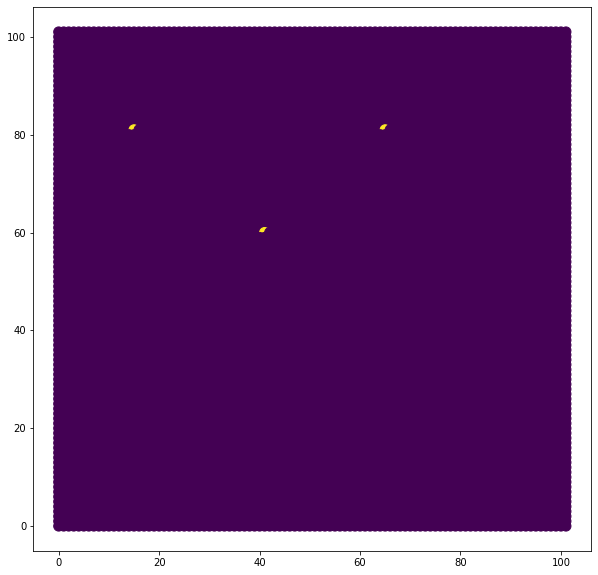

MovieWriter ffmpeg unavailable; using Pillow instead.


"\n# NOT-SO-GOOD VERSION\nnumpoints = 6724\npoints = [data[0]['x'], data[0]['y']]\ncolors = data[0]['density']\ncamera = Camera(plt.figure())\nfor i in range(len(data)):\n    points = [data[i]['x'], data[i]['y']]\n    colors = data[i]['density']\n    plt.scatter(*points, c=colors, s=100)\n    camera.snap()\nanim = camera.animate(blit=True)\nanim.save('scatter.gif')\n"

In [10]:
'''
# SEQUENTIAL PLOT
for i in range(len(data)):
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(data[i]['x'], data[i]['y'], c=data[i]['density'])
    ax.set_aspect(1)

    plt.show()
'''

# BETTER VERSION SO FAR
def main():
    numframes = 51   # len(data)
    numpoints = 6724
    color_data = C_data[0]['density']  #np.random.random((numframes, numpoints))  # THIS INSTEAD DOES SOMETHING SIMILAR
    x, y, c = C_data[0]['x'], C_data[0]['y'], C_data[0]['density']

    fig = plt.figure(figsize=(10, 10))
    scat = plt.scatter(x, y, c=c, s=100)

    ani = animation.FuncAnimation(fig, update_plot, frames=range(numframes),
                                  fargs=(color_data, scat))
    plt.show()
    ani.save('animation.gif')

def update_plot(i, custom_data, scat):
    scat.set_offsets(np.c_[C_data[i]['x'], C_data[i]['y']])
    scat.set_array(C_data[i]['density'])
    return scat,

main()


'''
# NOT-SO-GOOD VERSION
numpoints = 6724
points = [data[0]['x'], data[0]['y']]
colors = data[0]['density']
camera = Camera(plt.figure())
for i in range(len(data)):
    points = [data[i]['x'], data[i]['y']]
    colors = data[i]['density']
    plt.scatter(*points, c=colors, s=100)
    camera.snap()
anim = camera.animate(blit=True)
anim.save('scatter.gif')
'''